# LDA with Synonyms
It is an improvisation to the plain LDA model. In this model while comparing a word in a comment to the synopsis we also search for its similars words which are its synonyms. Wordnet Libray from NLTK library is used to get the synonyms.

# Importing important libraries

In [1]:
import pandas as pd
import re
import string
import sklearn
import csv
import nltk
from nltk.corpus import wordnet 

# Preprocessing of data

In [2]:
#comments dataset path (just change file name for different movies testing)
dataset_file="dataset_godfather.csv"
#synopsis text file path (just change file name for different movies testing)
synopsis_file='synopsis_godfather.txt'
df = pd.read_csv(dataset_file)
file = open(synopsis_file,"r")
text=file.read()
sentences = text.split('. ')
   
df2 = pd.DataFrame(sentences, columns=["synopsis"])
df2.to_csv('synopsis3.csv', index=False)
# print(df2.head())
df_pos=df.loc[df['is_spoiler'] == True]
df_neg=df.loc[df['is_spoiler'] == False]
pos_size=min(1000,df_pos.shape[0])
neg_size=min(1500,df_neg.shape[0])
print(pos_size,neg_size)
#Splitting dataset into train and test in 8:2 ratio
train_size=0.8*(pos_size+neg_size)
test_size=0.2*(pos_size+neg_size)
df_train_pos=df_pos.loc[:0.8*pos_size,:]
df_test_pos=df_pos.loc[0.8*pos_size+1:,:]
df_train_neg=df_neg.loc[:0.8*neg_size,:]
df_test_neg=df_neg.loc[0.8*neg_size+1:,:]
# df_train_neg.to_csv('train.csv', index=False)
frames_train=[df_train_pos,df_train_neg]
frames_test=[df_test_pos,df_test_neg]
df_train=pd.concat(frames_train)
df_test=pd.concat(frames_test)
df_train.to_csv('train.csv', index=False)
df_test.to_csv('test.csv', index=False)


420 1500


In [3]:
total_size=len(df.index)

In [4]:
#Appending Comment before index number in index column
index=[]
for i in range(len(df_train.index)):
    index.append("Comment "+str(i))
#df.insert(loc=0,column='index',value=index)
df_train['index']=index
df_train.set_index('index', inplace=True)

index2=[]
for i in range(len(df2.index)):
    index2.append("Comment "+str(i))
#df.insert(loc=0,column='index',value=index)
df2['index']=index2
df2.set_index('index', inplace=True)


In [5]:
#Function for preprocessing 
def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
round1 = lambda x: clean_text_round1(x)

In [6]:
#Cleaning both comments and synopsis data
data_clean = pd.DataFrame(df_train.review_text.apply(round1))
data_clean2 = pd.DataFrame(df2.synopsis.apply(round1))
# data_clean

# Preparing document term matrix

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

#Creating document term matrix for comments data with each entry denoting the count of the term in the comment
cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(data_clean.review_text)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = data_clean.index

#Creating document term matrix for synopsis data with each entry denoting the count of the term in the comment
cv2 = CountVectorizer(stop_words='english')
data_cv2 = cv2.fit_transform(data_clean2.synopsis)
data_dtm2 = pd.DataFrame(data_cv2.toarray(), columns=cv2.get_feature_names())
data_dtm2.index = data_clean2.index
print(data_dtm2.shape)
print(data_dtm.shape)


(101, 948)
(1118, 14087)


In [8]:
import numpy as np
from gensim import matutils, models
import scipy.sparse

In [9]:
#Creating id to word dictionary for comments data
id_word_dict={}
for i in range(len(data_dtm.columns)):
    id_word_dict[i]=data_dtm.columns[i]
#print(id_word_dict)
tdm = data_dtm.transpose()

#Creating id to word dictionary for synopsis data
id_word_dict2={}
for i in range(len(data_dtm2.columns)):
    id_word_dict2[i]=data_dtm2.columns[i]
# print(id_word_dict2)
tdm2 = data_dtm2.transpose()

In [10]:
#Converting the term document matrix in sparse matrix for preparing corpus of comments data
sparse_counts = scipy.sparse.csr_matrix(tdm)
corpus = matutils.Sparse2Corpus(sparse_counts)

#Converting the term document matrix in sparse matrix for preparing corpus of synopsis data
sparse_counts2 = scipy.sparse.csr_matrix(tdm2)
corpus2 = matutils.Sparse2Corpus(sparse_counts2)

# Testing the model.
###  Cosine similarity is used as a measure of similarity. A word is valid if it occurs in both comment and synopsis and with some threshold in the synopsis.
### The comment is considered as spoiler if its cosine similarity value crosses some threshold which is a hyperameter for our model.

In [11]:
def test_model(word_weight,word_weight_synopsis,threshold,threshold2):
    df3=pd.read_csv("test.csv")
    total_size=df3.shape[0]
    
    output_list=[]
    counter=0
    for j in range(total_size):
        comment_t=df3['review_text'][j]
        if df3['is_spoiler'][j] == 0:
            counter+=1

        comment_t=clean_text_round1(comment_t)
        s1=comment_t.split(" ")
        comment_ts=set(s1)
        comment_ts
        sum=0
        sum2=0
        sum3=0
        for i in word_weight_synopsis.values():
            sum3+=float(i)*float(i)  

        for wor in comment_ts:
            temp_max=0
            # populate the synonym list for each word and check it in the synopsis
            synonyms = []
            synonyms.append(wor);
            for syn in wordnet.synsets(wor): 
                for l in syn.lemmas(): 
                    synonyms.append(l.name()) 
            flag=False
            found_word="";
            for i in synonyms: 
                if i in word_weight :
                    found_word=i
                    flag=True                
                if i in word_weight_synopsis and i in word_weight and float(word_weight_synopsis[i])>threshold2:
                    temp_max=max(temp_max,float(word_weight_synopsis[i])*float(word_weight[i]))
                    found_word=i
                    break

            if flag==True:
                sum2+=float(word_weight[found_word])*float(word_weight[found_word])
                sum+=temp_max

        if sum2!=0 :
            #print(sum,sum2,sum3)
            output_list.append(sum/(np.sqrt(sum2)*np.sqrt(sum3)))
        else:
            output_list.append(0)
            
            
    df3['output']=output_list
    cols = list(df3.columns.values)
    df3 = df3[['Unnamed: 0', 'is_spoiler',  'output' ,'review_text']]
    df3.to_csv('final.csv')
    total=0
    false_positive=0
    false_negative=0
    true_positive=0
    true_negative=0

    # calculating the result of model and various parametrs such as fp,fn,tp,tn;
    for i in range(total_size):
        #print(df3['output'][i],threshold,df3['Y'][i])
        if df3['output'][i]>threshold and df3['is_spoiler'][i]==True  :
            true_positive+=1
        if  df3['output'][i]<threshold and df3['is_spoiler'][i]==False :
            true_negative+=1
        if df3['output'][i]>threshold and df3['is_spoiler'][i]==False:
            false_positive+=1
        if df3['output'][i]<threshold and df3['is_spoiler'][i]==True:
            false_negative+=1
    
    accuracy=(true_negative+true_positive)/total_size
    precision=true_positive/(true_positive+false_positive)
    recall=true_positive/(true_positive+false_negative)
    f1score=(2*precision*recall)/(precision+recall)
    return (true_positive,true_negative,false_positive,false_negative,f1score,accuracy)
        

### Solve function takes corpus, dictionary ,passes as arguments. It then trains the 2 lda models on the given parameters and returns word weight dictionry for both comments and synopsis.

In [12]:
def solve(total_topics,corpus,id_word_dict,corpus2,id_word_dict2,passes):
    lda = models.LdaMulticore(corpus=corpus, id2word=id_word_dict, num_topics=total_topics, passes=passes)
    lda2 = models.LdaMulticore(corpus=corpus2, id2word=id_word_dict2, num_topics=total_topics, passes=passes)
    
#storing dictionary of important words obtained by LDA on comments data and storing the maximum probability
#of that word occuring in any topic
# word weight dictionary comments
    word_weight={}    
    for i in range(total_topics):
        word_topic=lda.print_topic(i).split('+')
        j=0
        for word_probab in word_topic:
            val,wor=word_probab.split('*')
            wor=str(wor)
            y=len(wor)
            if j==len(word_topic)-1:
                wor = wor[1:y-1]
            else:
                wor = wor[1:y-2]
            if wor in word_weight:
                if word_weight[wor]<val:
                    word_weight[wor]=val
            else :
                 word_weight[wor]=val
            j=j+1
            
#storing dictionary of important words obtained by LDA on synopsis data and storing the maximum probability
#of that word occuring in any topic
# word weight dictionary synopsis
    word_weight_synopsis={}
    for i in range(total_topics):
        word_topic2=lda2.print_topic(i).split('+')
        j=0
        for word_probab in word_topic2:
            val,wor=word_probab.split('*')        
            wor=str(wor)
            #print(wor)
            y=len(wor)
            if j==len(word_topic2)-1:
                wor = wor[1:y-1]
            else:
                wor = wor[1:y-2]
            #print(wor)
            if wor in word_weight_synopsis:
                if word_weight_synopsis[wor]<val:
                    word_weight_synopsis[wor]=val
            else :
                 word_weight_synopsis[wor]=val

            j=j+1
            
    # evaluation
    return (word_weight,word_weight_synopsis)
       
    
    

In [13]:
total_topics=50
passes=20
(word_weight,word_weight_synopsis)=solve(total_topics,corpus,id_word_dict,corpus2,id_word_dict2,passes)


# Calculation of evaluation metrics for different values of threshold hyperparamete

In [14]:
# If you have to run using hyperparameter ( without using ranking mehod .)
# uncomment following code

# tp = []
# fp = []
# fn = []
# tn = []
# f1 = []
# acc =[]
threshold=0.11
threshold2=0.02
x=0
# for x in range(10):
#print(word_weight_synopsis)
(true_positive,true_negative,false_positive,false_negative,f1score,accuracy)=test_model(word_weight,word_weight_synopsis,threshold,threshold2)
#     print(total_size)
# tp.append(true_positive)
# tn.append(false_positive)
# fp.append(true_negative)
# fn.append(false_negative)
# f1.append(f1score)
# acc.append(accuracy)
# threshold+=0.01

# print(acc)
# print(f1)
# sample = open('godfather_result.txt',"a")
# print("iteration:\n",x,file = sample)
# print("\ntopic:",total_topics,file=sample)
# print( "\naccuracy:\n",acc , file = sample)
# print( "\ntrue_positive:\n",tp , file = sample)
# print( "\nfalse_positive:\n",fp , file = sample)
# print( "\ntrue_negative:\n",tn , file = sample)
# print( "\nfalse_negative:\n",fn , file = sample)
# print( "\nf1-score:\n",f1 ,file = sample)
# sample.close() 

    


In [15]:
# evaluation metrices for top K comments.(The comments are ranked based on cosine similarity values)
df4=pd.read_csv("final.csv")
df4.sort_values(by='output', ascending=False,inplace=True)
df4.to_csv('top_k.csv')
acc = []
pre = []
rec = []
klist = [100,150,200,250,300,350,400,450,500]
for top_k in klist:
    false_positive=0
    false_negative=0
    true_positive=0
    true_negative=0
    best_threshold= 0.11 # add best threshold obtained
    for i in range(top_k):
        if  df4['output'][i]>best_threshold and df4['is_spoiler'][i]==True  :
            true_positive+=1
        if  df4['output'][i]<best_threshold and df4['is_spoiler'][i]==False :
            true_negative+=1
        if  df4['output'][i]>best_threshold and df4['is_spoiler'][i]==False:
            false_positive+=1
        if  df4['output'][i]<best_threshold and df4['is_spoiler'][i]==True:
            false_negative+=1
    total_size = top_k
    accuracy = (true_positive+true_negative)/(total_size)
    acc.append(accuracy)
    precision=true_positive/(true_positive+false_positive)
    pre.append(precision)
    recall=true_positive/(true_positive+false_negative)
    rec.append(recall)

# print(acc)
# print(pre)
# print(rec)

[0.72, 0.6, 0.575, 0.564, 0.5366666666666666, 0.5514285714285714, 0.56, 0.5555555555555556, 0.552]
[0.9365079365079365, 0.6210526315789474, 0.49166666666666664, 0.4097222222222222, 0.3390804597701149, 0.3072916666666667, 0.2796208530805687, 0.251063829787234, 0.2277992277992278]
[0.7108433734939759, 0.7108433734939759, 0.7108433734939759, 0.7108433734939759, 0.7108433734939759, 0.7108433734939759, 0.7108433734939759, 0.7108433734939759, 0.7108433734939759]


In [16]:
# print(true_positive,true_negative,false_positive,false_negative,f1score,accuracy)
# df4

# Graphs  for ranking Method : 

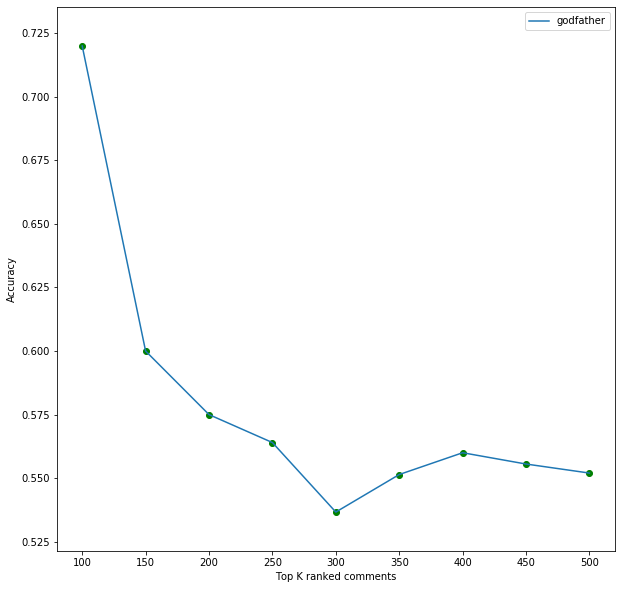

<Figure size 432x288 with 0 Axes>

In [20]:
# Graph of Accuracy vs  top k comments
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(10,10))

plt.scatter(klist,acc,marker='o' ,color='g')
line1,=plt.plot(klist,acc)

plt.legend((line1,), ('godfather',))
plt.xlabel('Top K ranked comments')
plt.ylabel('Accuracy')
plt.show()
plt.savefig("plot.jpeg")


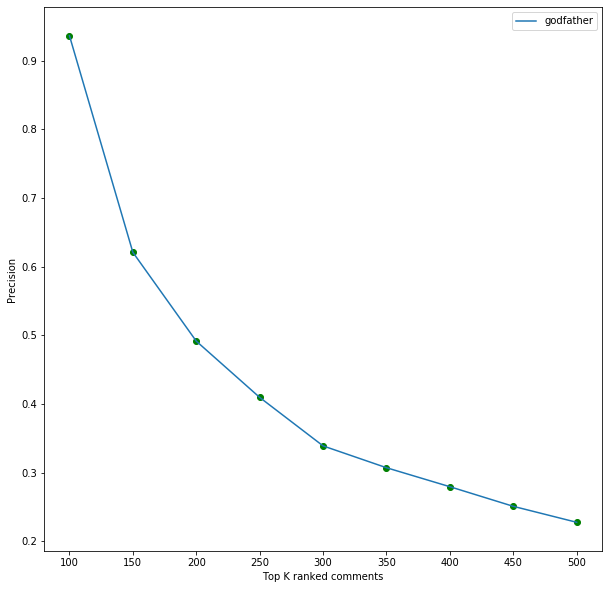

<Figure size 432x288 with 0 Axes>

In [18]:
# Graph of Precision vs top k comments
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(10,10))

plt.scatter(klist,pre,marker='o' ,color='g')
line1,=plt.plot(klist,pre)


plt.legend((line1,), ('godfather',))
plt.xlabel('Top K ranked comments')
plt.ylabel('Precision')
plt.show()
plt.savefig("plot.jpeg")


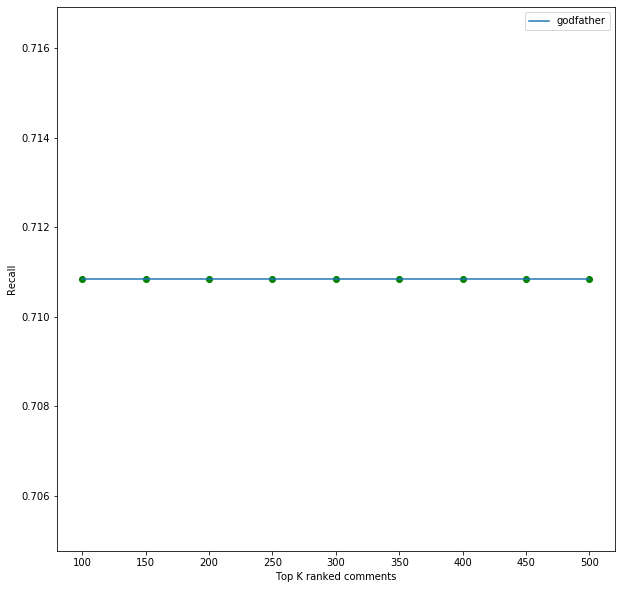

<Figure size 432x288 with 0 Axes>

In [19]:
#  Recall vs top k comments
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(10,10))


plt.scatter(klist,rec,marker='o' ,color='g')
line1,=plt.plot(klist,rec)


plt.legend((line1,), ('godfather',))
plt.xlabel('Top K ranked comments')
plt.ylabel('Recall')
plt.show()
plt.savefig("plot.jpeg")
